# Import Lib

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import (
    Input, Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Multiply, Add, Lambda, PReLU, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


from tqdm import tqdm
from scipy.fftpack import fft2, fftshift
import matplotlib.pyplot as plt
import shutil
import random
import kagglehub
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Dataset

In [2]:
# Define file paths in your Google Drive
train_csv_path = "/content/drive/MyDrive/432_Project/train.csv"
test_csv_path = "/content/drive/MyDrive/432_Project/test.csv"

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print(train_df.head())
print(test_df.head())
test_ids = test_df["id"]

   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [3]:
dataset_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

# Fix paths in train and test set to point to Kaggle dataset
train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(dataset_path, x))
test_df["id"] = test_df["id"].apply(lambda x: os.path.join(dataset_path, x))


# Check if files exist
print(train_df.head())
print(test_df.head())

100%|██████████| 9.76G/9.76G [07:25<00:00, 23.5MB/s]

Extracting files...


   Unnamed: 0                                          file_name  label
0           0  /root/.cache/kagglehub/datasets/alessandrasala...      1
1           1  /root/.cache/kagglehub/datasets/alessandrasala...      0
2           2  /root/.cache/kagglehub/datasets/alessandrasala...      1
3           3  /root/.cache/kagglehub/datasets/alessandrasala...      0
4           4  /root/.cache/kagglehub/datasets/alessandrasala...      1
                                                  id
0  /root/.cache/kagglehub/datasets/alessandrasala...
1  /root/.cache/kagglehub/datasets/alessandrasala...
2  /root/.cache/kagglehub/datasets/alessandrasala...
3  /root/.cache/kagglehub/datasets/alessandrasala...
4  /root/.cache/kagglehub/datasets/alessandrasala...


In [4]:
# Subset
subset_size = 30000

train_df["label"] = train_df["label"].astype(str)
train_data, _ = train_test_split(train_df, train_size=subset_size, stratify=train_df["label"], random_state=168)

# Split
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["label"], random_state=168)
print(train_data.head())
print(val_data.head())
print(test_df.head())

       Unnamed: 0                                          file_name label
14877       14877  /root/.cache/kagglehub/datasets/alessandrasala...     0
28963       28963  /root/.cache/kagglehub/datasets/alessandrasala...     0
16774       16774  /root/.cache/kagglehub/datasets/alessandrasala...     1
26718       26718  /root/.cache/kagglehub/datasets/alessandrasala...     1
21096       21096  /root/.cache/kagglehub/datasets/alessandrasala...     1
       Unnamed: 0                                          file_name label
57595       57595  /root/.cache/kagglehub/datasets/alessandrasala...     0
24452       24452  /root/.cache/kagglehub/datasets/alessandrasala...     1
64899       64899  /root/.cache/kagglehub/datasets/alessandrasala...     0
53510       53510  /root/.cache/kagglehub/datasets/alessandrasala...     1
67894       67894  /root/.cache/kagglehub/datasets/alessandrasala...     1
                                                  id
0  /root/.cache/kagglehub/datasets/alessandrasa

In [5]:
print(train_data.shape)


(24000, 3)


# Preprocessing

## Frequency Domain Branch

In [6]:
# def process_frequency_domain(image_path, original_size=(256, 256), target_size=(64, 64)):
#     """Process an image by applying hierarchical frequency domain transformation and then max-pooling to 64×64."""

#     # Load image in grayscale
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, original_size)  # Ensure consistent input size

#     freq_blocks = []

#     def apply_dft(block):
#         """Apply DFT and log magnitude transformation."""
#         dft = np.fft.fft2(block)
#         dft_shift = np.fft.fftshift(dft)
#         magnitude = np.abs(dft_shift)
#         return np.log(1 + magnitude)  # Log scaling for better range

#     # **1. Full Image (256×256)**
#     freq_blocks.append(apply_dft(img))

#     # **2. Split into 4 Blocks (128×128 each)**
#     mid = original_size[0] // 2  # 128
#     first_level_blocks = [
#         img[:mid, :mid],  # Top-left
#         img[:mid, mid:],  # Top-right
#         img[mid:, :mid],  # Bottom-left
#         img[mid:, mid:]   # Bottom-right
#     ]

#     for block in first_level_blocks:
#         freq_blocks.append(apply_dft(block))

#     # **3. Further Split each 128×128 block into 16 smaller (64×64) blocks**
#     for block in first_level_blocks:
#         h, w = block.shape
#         step = h // 2  # 64
#         second_level_blocks = [
#             block[:step, :step], block[:step, step:],
#             block[step:, :step], block[step:, step:]
#         ]
#         for sub_block in second_level_blocks:
#             freq_blocks.append(apply_dft(sub_block))

#     # **4. Resize ALL Blocks to (64×64)**
#     resized_blocks = [cv2.resize(block, target_size) for block in freq_blocks]

#     # **5. Stack into Tensor and Apply Global Max Pooling**
#     freq_blocks_tensor = np.stack(resized_blocks, axis=0)  # Shape: (21, 64, 64)
#     pooled_freq = np.max(freq_blocks_tensor, axis=0)  # Pooling → (64, 64)

#     # **6. Ensure Final Shape for CNN Input (64, 64, 1)**
#     pooled_freq = np.expand_dims(pooled_freq, axis=-1)  # Add channel dimension

#     return pooled_freq  # Single (64, 64, 1) output


In [7]:
def process_frequency_domain(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Cannot read image at {image_path}")
        return None
    img = cv2.resize(img, img_size)

    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = np.log(1 + np.abs(dft_shift))

    return magnitude_spectrum[..., np.newaxis]  # Add channel dimension

In [8]:
# **Test the function**
image_path = train_data.iloc[0]["file_name"]
freq_block = process_frequency_domain(image_path)

print(f"Processed Frequency Block Shape: {freq_block.shape}")

Processed Frequency Block Shape: (128, 128, 1)


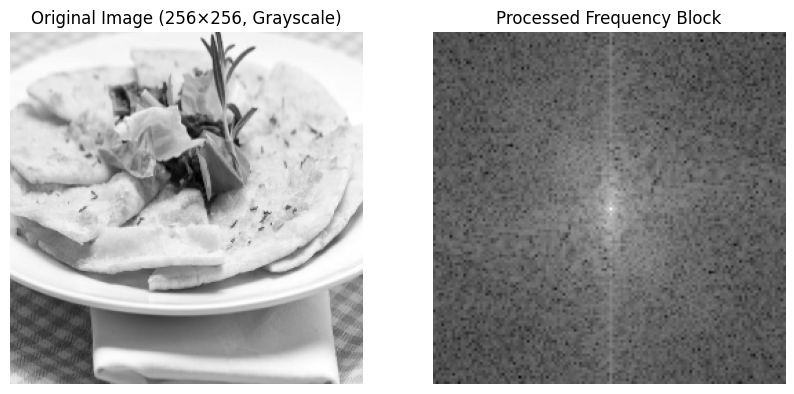

In [9]:
# **Plot**
def plot_frequency_block(original_image_path, freq_block):
    """Plots the original image alongside the processed frequency domain block."""

    # Load and resize the original image for comparison
    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    original_img = cv2.resize(original_img, (256, 256))  # Ensure correct size for visualization

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # **Plot Original Image (Grayscale)**
    axes[0].imshow(original_img, cmap="gray")
    axes[0].set_title("Original Image (256×256, Grayscale)")
    axes[0].axis("off")

    # **Plot Processed Frequency Domain Block**
    axes[1].imshow(freq_block[:, :, 0], cmap="gray")  # Remove channel dim for visualization
    axes[1].set_title("Processed Frequency Block")
    axes[1].axis("off")

    plt.show()

plot_frequency_block(image_path, freq_block)

## Spatial Domain

In [ ]:
# def process_spatial_domain(image_path, original_size=(256, 256), target_size=(128, 128)):
#     """Processes an image by applying hierarchical spatial blocking and pooling to a final 64×64 representation."""

#     # Load image in color (RGB format)
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
#     img = cv2.resize(img, original_size)  # Ensure consistent input size

#     spatial_blocks = []

#     # **1. Full Image (256x256, 3 channels)**
#     spatial_blocks.append(img)

#     # **2. Split into 4 Blocks (128x128 each)**
#     mid = original_size[0] // 2  # 128
#     first_level_blocks = [
#         img[:mid, :mid, :],  # Top-left
#         img[:mid, mid:, :],  # Top-right
#         img[mid:, :mid, :],  # Bottom-left
#         img[mid:, mid:, :]   # Bottom-right
#     ]

#     for block in first_level_blocks:
#         spatial_blocks.append(block)

#     # **3. Further Split each 128x128 block into 16 smaller (64x64) blocks**
#     for block in first_level_blocks:
#         h, w, c = block.shape  # Correctly unpack height, width, channels
#         step = h // 2  # 64
#         second_level_blocks = [
#             block[:step, :step, :], block[:step, step:, :],
#             block[step:, :step, :], block[step:, step:, :]
#         ]
#         for sub_block in second_level_blocks:
#             spatial_blocks.append(sub_block)

#     # **4. Resize ALL Blocks to (64×64)**
#     resized_blocks = [cv2.resize(block, target_size) for block in spatial_blocks]

#     # **5. Stack into Tensor and Apply Global Max Pooling**
#     spatial_blocks_tensor = np.stack(resized_blocks, axis=0)  # Shape: (21, 64, 64, 3)
#     pooled_spatial = np.max(spatial_blocks_tensor, axis=0)  # Pooling → (64, 64, 3)

#     # **6. Normalize Pixel Values to [0,1]**
#     pooled_spatial = pooled_spatial.astype("float32") / 255.0

#     return pooled_spatial  # Final spatial representation (64, 64, 3)


In [10]:
def process_spatial_domain(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error: Cannot read image at {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size) / 255.0  # Normalize

    return img

In [11]:
# **Test the function**
image_path = train_data.iloc[0]["file_name"]
spatial_block = process_spatial_domain(image_path)

print(f"Processed Spatial Block Shape: {spatial_block.shape}")

Processed Spatial Block Shape: (128, 128, 3)


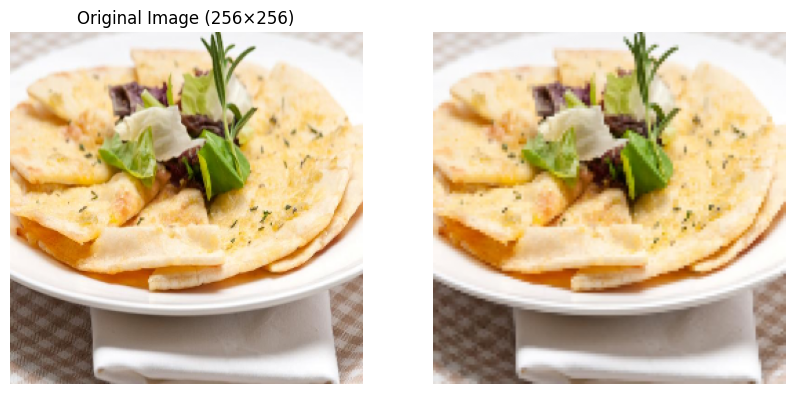

In [12]:
# **Plot**
def plot_spatial_block(original_image_path, spatial_block):
    """Plots the original image alongside the processed spatial domain block."""

    # Load and resize the original image for comparison
    original_img = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    original_img = cv2.resize(original_img, (256, 256))  # Ensure correct size for visualization

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # **Plot Original Image**
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image (256×256)")
    axes[0].axis("off")

    # **Plot Processed Spatial Domain Block**
    axes[1].imshow(spatial_block)
    axes[1].axis("off")

    plt.show()
plot_spatial_block(image_path, spatial_block)

In [ ]:
# def preprocess_data(df, augment=False):
#     freq_features, spatial_features, labels = [], [], []

#     for _, row in df.iterrows():
#         image_path = row["file_name"]
#         label = row["label"]

#         freq_block = process_frequency_domain(image_path)
#         spatial_block = process_spatial_domain(image_path)

#         if freq_block is not None and spatial_block is not None:
#             freq_features.append(freq_block)
#             spatial_features.append(spatial_block)
#             labels.append(label)

#     freq_features = np.array(freq_features, dtype=np.float32)
#     spatial_features = np.array(spatial_features, dtype=np.float32)
#     labels = np.array(labels, dtype=np.float32)

#     if augment:
#         return augment_spatial_data(freq_features, spatial_features, labels)

#     return freq_features, spatial_features, labels

# def augment_spatial_data(X_freq, X_spatial, y):
#     datagen = ImageDataGenerator(
#         horizontal_flip=True,
#         rotation_range=10,
#         zoom_range=0.1,
#         width_shift_range=0.1,
#         height_shift_range=0.1
#     )

#     augmented_iter = datagen.flow(X_spatial, y, batch_size=len(X_spatial), shuffle=False)

#     # Fix: Use __getitem__(0) instead of next()
#     X_spatial_augmented, y_augmented = augmented_iter.__getitem__(0)

#     return X_freq, X_spatial_augmented, y_augmented

In [ ]:
# X_freq_train, X_spatial_train, y_train = preprocess_data(train_data, augment=True)
# X_freq_val, X_spatial_val, y_val = preprocess_data(val_data, augment=False)

# print(f"Training Shapes: {X_freq_train.shape}, {X_spatial_train.shape}, {y_train.shape}")
# print(f"Validation Shapes: {X_freq_val.shape}, {X_spatial_val.shape}, {y_val.shape}")

Training Shapes: (24000, 128, 128, 1), (24000, 128, 128, 3), (24000,)
Validation Shapes: (6000, 128, 128, 1), (6000, 128, 128, 3), (6000,)


## augmentation only on minority class



In [13]:
def preprocess_data(df, augment=False):
    freq_features, spatial_features, labels = [], [], []

    for _, row in df.iterrows():
        image_path = row["file_name"]
        label = row["label"]

        freq_block = process_frequency_domain(image_path)
        spatial_block = process_spatial_domain(image_path)

        if freq_block is not None and spatial_block is not None:
            freq_features.append(freq_block)
            spatial_features.append(spatial_block)
            labels.append(label)

    # Convert to numpy arrays
    freq_features = np.array(freq_features, dtype=np.float32)
    spatial_features = np.array(spatial_features, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    if augment:
        return augment_minority_class(freq_features, spatial_features, labels)

    return freq_features, spatial_features, labels

def augment_minority_class(X_freq, X_spatial, y):
    """
    Applies data augmentation only to the minority class.
    """
    minority_class = 1

    # Separate the minority class samples
    minority_indices = np.where(y == minority_class)[0]
    X_freq_minority = X_freq[minority_indices]
    X_spatial_minority = X_spatial[minority_indices]
    y_minority = y[minority_indices]

    # Define ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=15,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    # Generate augmented data (same amount as original minority samples)
    augmented_iter = datagen.flow(X_spatial_minority, y_minority, batch_size=len(y_minority), shuffle=False)
    X_spatial_augmented, y_augmented = augmented_iter.__getitem__(0)

    # Duplicate frequency domain data (since it's not augmented)
    X_freq_augmented = np.copy(X_freq_minority)

    # Combine augmented and original data
    X_freq_balanced = np.concatenate([X_freq, X_freq_augmented], axis=0)
    X_spatial_balanced = np.concatenate([X_spatial, X_spatial_augmented], axis=0)
    y_balanced = np.concatenate([y, y_augmented], axis=0)

    print(f"After Augmentation: Class {minority_class} increased from {len(y_minority)} to {len(y_minority) * 2}")

    return X_freq_balanced, X_spatial_balanced, y_balanced

In [14]:
X_freq_train, X_spatial_train, y_train = preprocess_data(train_data, augment=True)
X_freq_val, X_spatial_val, y_val = preprocess_data(val_data, augment=False)

print(f"Training Shapes: {X_freq_train.shape}, {X_spatial_train.shape}, {y_train.shape}")
print(f"Validation Shapes: {X_freq_val.shape}, {X_spatial_val.shape}, {y_val.shape}")

After Augmentation: Class 1 increased from 12000 to 24000
Training Shapes: (36000, 128, 128, 1), (36000, 128, 128, 3), (36000,)
Validation Shapes: (6000, 128, 128, 1), (6000, 128, 128, 3), (6000,)


# Model

## model4

In [29]:
def frequency_branch(input_shape):
    inp = Input(shape=input_shape, name="Frequency_Input")

    x = Conv2D(64, (3, 3), padding="same")(inp)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    # x = Conv2D(256, (3, 3), padding="same")(x)  # **Added a third Conv layer**
    # x = LeakyReLU(alpha=0.01)(x)
    # x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)

    return Model(inp, x, name="Frequency_Branch")

def spatial_branch(input_shape):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
    base_model.trainable = False  # Freeze initial layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)

    return Model(base_model.input, x, name="Spatial_Branch")

In [30]:
def build_dual_branch_model():
    freq_model = frequency_branch((128, 128, 1))
    spatial_model = spatial_branch((128, 128, 3))

    merged = Concatenate()([freq_model.output, spatial_model.output])

    x = Dense(512, activation="relu")(merged)  # **Increased to 512**
    x = Dropout(0.5)(x)  # **Increased dropout slightly**
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    output = Dense(1, activation="sigmoid", name="Output")(x)

    return Model(inputs=[freq_model.input, spatial_model.input], outputs=output, name="Dual_Branch_Network")

dual_branch_model = build_dual_branch_model()
dual_branch_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Dual_Branch_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 128, 128, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,601,252 (17.55 MB)

 Trainable params: 551,297 (2.10 MB)

 Non-trainable params: 4,049,955 (15.45 MB)

## model5

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Frequency Domain Branch (DFT Features)
def frequency_branch(input_shape):
    inp = Input(shape=input_shape, name="Frequency_Input")

    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(inp)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)

    return Model(inp, x, name="Frequency_Branch")

# Spatial Domain Branch (EfficientNet Features)
def spatial_branch(input_shape):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")

    # Fine-tuning: Unfreeze last few layers
    for layer in base_model.layers[-5:]:
        layer.trainable = True  # Allow last 5 layers to train

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)

    return Model(base_model.input, x, name="Spatial_Branch")

# Combined Dual Branch Model
def build_dual_branch_model():
    freq_model = frequency_branch((128, 128, 1))
    spatial_model = spatial_branch((128, 128, 3))

    merged = Concatenate()([freq_model.output, spatial_model.output])

    x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    output = Dense(1, activation="sigmoid", name="Output")(x)

    return Model(inputs=[freq_model.input, spatial_model.input], outputs=output, name="Dual_Branch_Network")

dual_branch_model = build_dual_branch_model()
dual_branch_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Dual_Branch_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 128, 128, 3)    │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,601,252 (17.55 MB)

 Trainable params: 4,558,845 (17.39 MB)

 Non-trainable params: 42,407 (165.66 KB)

# Train

In [42]:
optimizer = Adam(learning_rate=1e-4)
dual_branch_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

history = dual_branch_model.fit(
    [X_freq_train, X_spatial_train], y_train,
    validation_data=([X_freq_val, X_spatial_val], y_val),
    batch_size=32,
    epochs=2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 120s 41ms/step - accuracy: 0.8368 - loss: 0.4700 - val_accuracy: 0.8207 - val_loss: 0.5398 - learning_rate: 1.0000e-04
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.9659 - loss: 0.2174 - val_accuracy: 0.8500 - val_loss: 0.4770 - learning_rate: 1.0000e-04
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.9801 - loss: 0.1680 - val_accuracy: 0.7970 - val_loss: 0.6591 - learning_rate: 1.0000e-04
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.9877 - loss: 0.1387 - val_accuracy: 0.9292 - val_loss: 0.3125 - learning_rate: 1.0000e-04
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - accuracy: 0.9904 - loss: 0.1229 - val_accuracy: 0.8022 - val_loss: 0.8627 - learning_rate: 1.0000e-04


# Save

In [43]:
dual_branch_model.save("/content/drive/MyDrive/432_Project/dual_branch_model5.h5")  # Saves as a single .h5 file


# Prediction

In [44]:
from sklearn.metrics import f1_score

# Get predicted probabilities on validation set
y_val_probs = dual_branch_model.predict([X_freq_val, X_spatial_val])

# Try different thresholds and find the best one
best_threshold = 0.5
best_f1 = 0


for threshold in np.arange(0.1, 0.9, 0.01):  # Test different thresholds
    y_val_preds = (y_val_probs >= threshold).astype(int)
    f1 = f1_score(y_val, y_val_preds)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold for F1-score: {best_threshold}, F1-score: {best_f1}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step
Best Threshold for F1-score: 0.47999999999999976, F1-score: 0.9288940940271039


In [19]:
def preprocess_test_data(df):
    freq_features, spatial_features = [], []

    for _, row in df.iterrows():
        image_path = row["id"]

        freq_block = process_frequency_domain(image_path)
        spatial_block = process_spatial_domain(image_path)

        if freq_block is not None and spatial_block is not None:
            freq_features.append(freq_block)
            spatial_features.append(spatial_block)

    freq_features = np.array(freq_features, dtype=np.float32)
    spatial_features = np.array(spatial_features, dtype=np.float32)

    return freq_features, spatial_features

test_freq, test_spatial = preprocess_test_data(test_df)

In [45]:
y_test_probs = dual_branch_model.predict([test_freq, test_spatial])
y_test_labels = (y_test_probs > 0.47999999999999976).astype(int)

submission_df = pd.DataFrame({"id": test_ids, "label": y_test_labels.flatten()})
submission_df.to_csv("submission.csv", index=False)
print(submission_df["label"].value_counts())
print("Submission file saved as submission.csv")

174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
label
0    4650
1     890
Name: count, dtype: int64
Submission file saved as submission.csv


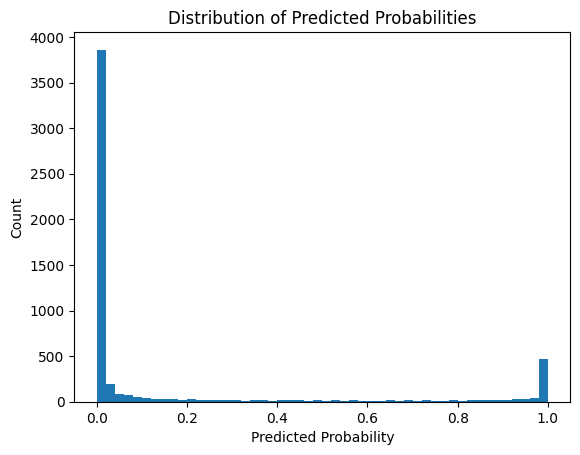

In [46]:
plt.hist(y_test_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.show()